<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 40% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ROMY - <br> Sagnac Demodulation </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

# Demodulation of Sagnac Signal

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import matplotlib.pyplot as plt
import obspy 
import time

from scipy import optimize
from scipy.signal import  hilbert, decimate, resample


### Defining Methods

In [2]:
from EchoPerformance import __echo_performance
from LoadSignalMseed import __load_signal_mseed

In [3]:

def __insta_freq_sinus_fit(time, signal, samples_to_fit, shift_samples, sgnc):

    '''
    Fitting a sin-function to the resampled data to
    estimate an instantaneous frequency 
    
    '''
    
    from tqdm import tqdm 
    
    
    ## check if samples_to_fit is an even integer
    if str(type(samples_to_fit)) != "<class 'int'>" or samples_to_fit%2 != 0:
        print("samples_to_fit should be an even integer") 
    
    hs = int(samples_to_fit/2)
    
    
    ## hanning tapered sine function 
    def func(x, a, b): 
        return a * np.sin(2*np.pi* b * x) * np.hanning(len(x))

    
    ## get delta t
    if abs((time[2]-time[1]) - (time[-2]-time[-3])) > 1e-10:
        print("problem with sampling interval!")
    else:
        dt = (time[2]-time[1])
    
        
    amps=[]
    freq=[]

    ## create time refernce 
    tt = np.arange(samples_to_fit/2, len(time)-samples_to_fit/2, shift_samples) 

    
    for idx in tqdm(tt):

        idx = int(idx)
        
        ## start values for fitting
        a0 = 0.9
        b0 = 54
        b1 = sgnc
        
        ## condition for fit
        while abs(b0-b1) > 0.05:
            b0 = b1
            params, params_covariance = optimize.curve_fit(func, time[idx-hs:idx+hs], 
                                                           np.hanning(len(signal[idx-hs:idx+hs]))*signal[idx-hs:idx+hs],
                                                           p0=[a0, b0]
                                                          )
            b1 = params[1]


        amps.append(params[0])
        freq.append(params[1])
    
    ## convert lists to arrays
    amps = np.array(amps)
    freq = np.array(freq)
    
    
    ## instert nan value for time zero (exluded because of np.diff() ) 
    #freq = np.insert(freq, 0, np.nan, axis=0)
    #tt   = np.insert(tt, 0, 0.0, axis=0)
    for f in freq:
        if f == 0:
            print("at least one frequency estimated to zero!")
        if str(f) == "nan":
            print("at least one frequency estimated to nan!")
           
        
    ## extend frequency array for one sample at start and end 
    #frequencies = np.concatenate((np.zeros(1), freq, np.zeros(1)), axis=0)       
    frequencies = np.concatenate((np.ones(1)*sgnc, freq, np.ones(2)*sgnc), axis=0)       

    ## calculate correct timeline
    delta = dt*shift_samples
    times = np.arange(0,len(frequencies)*delta,delta)
                                
    print(len(time), len(signal), ) 
    print(len(frequencies), len(times), times[0], times[-1])

    
    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    
    i = 30
    idx1 = i - hs
    idx2 = i + hs
    
    xx = np.linspace(time[idx1],time[idx2],samples_to_fit*8) 
    
    ax.scatter(time[idx1:idx2],np.hanning(len(signal[idx1:idx2]))*signal[idx1:idx2],s=10,color='black')
    ax.plot(xx,func(xx,params[0],params[1]),color='red')



    plt.show();
    
    ## _______________________________________________________________________________
   
    
    return  times , frequencies


In [4]:

def __insta_freq_hilbert(sig_in, time_in, fs):
    
    ''' Estimation of the instantaneous frequency (modulated signal) by using integrated python methods '''
    
    sig_hil = hilbert(sig_in)
    
    insta_phase = np.unwrap(np.angle(sig_hil))
    
    insta_freq  = 2* (np.diff(insta_phase) / (2.0 * np.pi)  * fs)

    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    insta_freq = np.insert(insta_freq, 0, np.nan, axis=0)
    

    return time_in, insta_freq


In [5]:

def __hibert_filter(sig_in, time_in, fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''
    
    hil0 = hilbert(sig_in)
    hil = np.imag(hil0)
    
    delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*(sig_in[1:]**2 + hil[1:]**2))

    delta_f = np.real(delta_f_full)
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    delta_f = np.insert(delta_f, 0, np.nan, axis=0)

    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

#    ax.plot(time_in[1:],delta_f,color='grey')
    ax.plot(time_in,delta_f,color='grey')

    x1=5
    x2=10

    ax.set_xlim(x1,x2)
    ax.set_ylim(min(delta_f[int(x1*fs):int(x2*fs)])-0.5,max(delta_f[int(x1*fs):int(x2*fs)])+0.5)

    ax.set_ylabel('$\Delta$ f (Hz)')
    ax.set_xlabel('Time (s)')
    
    plt.show();    
    
    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


### Load Plotting Methods

In [6]:
from MakeplotSignalComparison import __makeplot_signal_comparison
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum

In [7]:

def __makeplot_results(time_syn_event, syn_event, time_demod_signal, demod_signal, case, cut_edges=None):


    def __normalize(array):
        return array/max(abs(array))
    
    
    ## check for NaN and replace them, if encountered
    from math import isnan
    
    k=0
    for i, j in enumerate(demod_signal):
        if isnan(j):
            demod_signal[i] = sgnc
            k+=1
    if k > 0:
        print(f'\n{k} NaN found and replaced with Sagnac frequency: {sgnc} Hz\n')
    
    print(demod_signal.size)
    if cut_edges is not None :
        num = cut_edges * 5000 # 5000 = 1 sec
        syn_event = syn_event[num:-num]
        time_syn_event = time_syn_event[num:-num]
        demod_signal = demod_signal[num:-num]
        time_demod_signal = time_demod_signal[num:-num]
    print(demod_signal.size)
    
    
    ## interpolation of demodulated signal to match event size
    syn_event_interpol = np.interp(time_demod_signal, time_syn_event ,syn_event)
    print("interpolating ... ")
    
    ## remove offset 
    demod_signal = demod_signal - np.median(demod_signal)
    print("remove mean of demodulated signal ...")
    
    ## normalize signals 
    syn_event_interpol_norm = __normalize(syn_event_interpol)
    demod_signal_norm = __normalize(demod_signal)
    print("normalizing signals ...")
    
    ## calulcate difference between original and demodulated   
    difference = syn_event_interpol_norm - demod_signal_norm
    
    
    print(f'\nmaximal amplitude:')
    print(f'\n original: {round(max(demod_signal),10)}')
    print(f'\n demodulated: {round(max(syn_event_interpol),10)}')
    print(f'\n residual: {round(max(difference),10)}')

    ## _________________________________________________________
    ## plotting 
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,5), sharex=True)
    
    plt.subplots_adjust(hspace=0.4)
    
    font=14
    
    ax1.plot(time_demod_signal, 
             syn_event_interpol_norm, 
             label="original",
            )
    
#     demod_signal-np.mean(demod_signal))/max(abs(demod_signal-np.mean(demod_signal)))
    ax2.plot(time_demod_signal, 
             demod_signal_norm, 
             color='darkorange',
             label='demodulated',
            )
    
    ax3.plot(time_demod_signal, 
             difference, 
             color='k',
             label='residual',
            )

    
    ax1.tick_params(axis='both', labelsize=font)
    ax2.tick_params(axis='both', labelsize=font)
    ax3.tick_params(axis='both', labelsize=font)
    
    ax1.set_title("normalized signals and residual", fontsize=font+2)
    ax3.set_xlabel("Time (s)", fontsize=font)
    
    ax1.legend(loc='upper right', fontsize=font-2); 
    ax2.legend(loc='upper right', fontsize=font-2); 
    ax3.legend(loc='upper right', fontsize=font-2)
    
    plt.show();
    
    return fig


### Parameters Settings

In [23]:
## dividing by
div = 1

## set Parameters -------------------------------------

## assumed sagnac frequency 
sgnc = 550/div

## sampling, time duration and points 
sps = 5000/div # samples per second
T   = 1600/div # seconds
pts = sps * T # points

## choose which signal is loaded
signal_option = 2


### Load Synthetic Signal

The modulated signal and used event traces of the modulation notebook are loaded and assigned to arrays

In [22]:
# __load_signal_mseed(option)

## load signal and assign arrays
signal = obspy.read(f"synthetic_signal_opt{signal_option}.mseed")

synthetic_signal = signal[0].data
time_synthetic_signal = signal[1].data

## load event and assign arrays
event = obspy.read(f"synthetic_event_opt{signal_option}.mseed")

synthetic_event = event[0].data
time_synthetic_event = event[1].data

## Demodulation

### Instantaneous Frequency with Sine Fitting

100%|██████████| 1599999/1599999 [07:38<00:00, 3491.29it/s]


8000001 8000001
1600002 1600002 0.0 1600.001


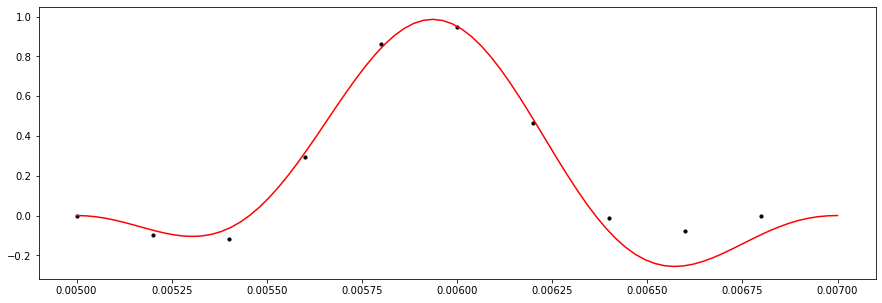


 fitting every 5 samples over 10 samples

 elapsed time: 7 min 40.77 sec

_____________________________
1600002
1550002
interpolating ... 
remove mean of demodulated signal ...
normalizing signals ...

maximal amplitude:

 original: 9.89414e-05

 demodulated: 0.6158491108

 residual: 1.017978198


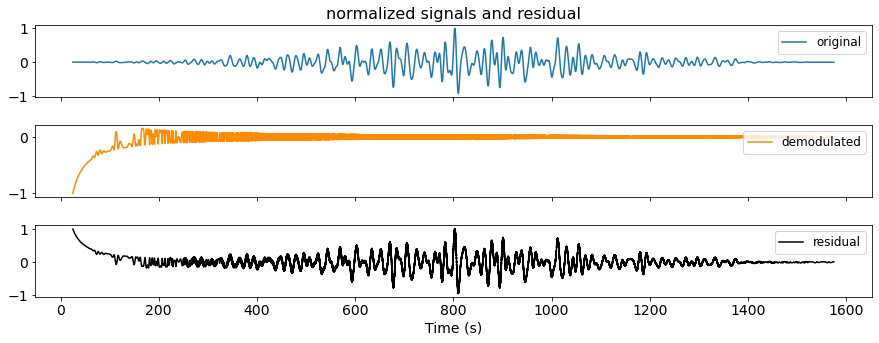

In [24]:
option = 1

samples_to_fit = 10
shift_samples = 5

tclock1 = time.time()

time_demod_signal, demod_signal = __insta_freq_sinus_fit(time_synthetic_signal, 
                                                         synthetic_signal, 
                                                         samples_to_fit, 
                                                         shift_samples, 
                                                         sgnc,
                                                         ); 


tclock2 = time.time()

print(f"\n fitting every {shift_samples} samples over {samples_to_fit} samples")

__echo_performance(tclock1, tclock2)

print('\n_____________________________')


## _________________________________________
## Plotting

__makeplot_results(time_synthetic_event,
                   synthetic_event,
                   time_demod_signal,
                   demod_signal,
                   case = option,
                   cut_edges = 5,
                  );

### Instantaneous Frequency with Hilbert 


 elapsed time: 3.23 sec

_____________________________

1 NaN found and replaced with Sagnac frequency: 550.0 Hz

8000001
7950001
interpolating ... 
remove mean of demodulated signal ...
normalizing signals ...

maximal amplitude:

 original: 6.9538549847

 demodulated: 0.6158491165

 residual: 1.422937554


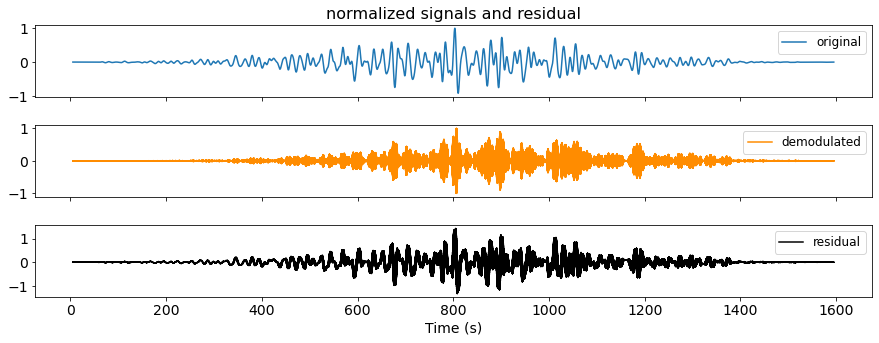

In [25]:
option = 2

tclock1 = time.time()

time_demod_signal, demod_signal = __insta_freq_hilbert(synthetic_signal, 
                                                       time_synthetic_signal, 
                                                       sps,
                                                       );


tclock2 = time.time()


__echo_performance(tclock1, tclock2)

print('\n_____________________________')

## _________________________________________
## Plotting

__makeplot_results(time_synthetic_event,
                   synthetic_event,
                   time_demod_signal,
                   demod_signal,
                   case = option,
                   cut_edges = 5,
                  );



#### Instantaneous Frequency with Hilbert Filter

In [12]:
# _____________________________________________________________________________________________________________
tt_demod, sig_demod = __hibert_filter(sig_dig_res,tt_res,fs_digi) ; option = 'option3'

__makeplot_results(time_sythetic_event, synthetic_event, tt_demod, sig_demod);


NameError: name 'time_sythetic_event' is not defined

### Other

9.9953116995682183e-21